In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import roc_auc_score

# Prepare data

* Attributed rate: how attribution is distributed in combinations
* Click counts: how clicks are distributed in combinations
* Rolling click counts: how clicks are distributed in combinations in sliding windows

In [2]:
hdf_path = '../derived_data/source.hdf'

In [3]:
res_hdf_path = '../derived_data/feats_pile.hdf'

In [4]:
%%time
dat = pd.read_hdf(hdf_path, key='train')

CPU times: user 320 ms, sys: 4.78 s, total: 5.1 s
Wall time: 19.7 s


In [5]:
dat.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [6]:
train = dat.loc[(dat.click_time >= '2017-11-09 04:00:00') & (dat.click_time < '2017-11-09 15:00:00')].copy()

In [7]:
train_len = train.shape[0]

In [8]:
test = pd.read_hdf(hdf_path, key='test')

In [9]:
train = train.append(test)

In [10]:
train.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os
144708152,2,477,NaN,2017-11-09 04:00:00,1,38877,0.0,19
144708153,14,489,NaN,2017-11-09 04:00:00,1,104271,0.0,18
144708154,3,280,NaN,2017-11-09 04:00:00,1,92922,0.0,13
144708155,3,19,NaN,2017-11-09 04:00:00,1,6505,0.0,13
144708156,9,334,NaN,2017-11-09 04:00:00,1,19964,0.0,13


In [11]:
del dat
del test

In [12]:
gc.collect()

223

In [13]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

In [14]:
uint8_max = np.iinfo(np.uint8).max
uint16_max = np.iinfo(np.uint16).max
uint32_max = np.iinfo(np.uint32).max
int8_max = np.iinfo(np.int8).max
int16_max = np.iinfo(np.int16).max
int32_max = np.iinfo(np.int32).max
def choose_uint_type(n):
    if n <= uint8_max:
        return 'uint8'
    elif n <= uint16_max:
        return 'uint16'
    elif n <= uint32_max:
        return 'uint32'
    else:
        return 'uint64'
def choose_int_type(n):
    if n <= int8_max:
        return 'int8'
    elif n <= int16_max:
        return 'int16'
    elif n <= int32_max:
        return 'int32'
    else:
        return 'int64'

In [15]:
def get_next_click(df, selcols):
    gp = df.groupby(selcols)
    next_click_col = 'nextclick_{}'.format('_'.join(selcols))
    next_click = (gp['epochtime'].shift(-1) - df.epochtime).fillna(-1)
    next_click = next_click.astype(choose_int_type(next_click.max()))
    next_click.name = next_click_col
    next_click = next_click.to_frame()
    df = pd.concat([df, next_click], axis=1)
    del gp
    del next_click
    gc.collect()
    return df

In [15]:
def get_previous_click(df, selcols):
    gp = df.groupby(selcols)
    previous_click_col = 'previousclick_{}'.format('_'.join(selcols))
    previous_click = (df.epochtime - gp['epochtime'].shift(1)).fillna(-1)
    previous_click = previous_click.astype(choose_int_type(previous_click.max()))
    previous_click.name = previous_click_col
    previous_click = previous_click.to_frame()
    df = pd.concat([df, previous_click], axis=1)
    del gp
    del previous_click
    gc.collect()
    return df

In [16]:
def get_previousprevious_click(df, selcols):
    gp = df.groupby(selcols)
    previous_click_col = 'previouspreviousclick_{}'.format('_'.join(selcols))
    previous_click = (df.epochtime - gp['epochtime'].shift(2)).fillna(-1)
    previous_click = previous_click.astype(choose_int_type(previous_click.max()))
    previous_click.name = previous_click_col
    previous_click = previous_click.to_frame()
    df = pd.concat([df, previous_click], axis=1)
    del gp
    del previous_click
    gc.collect()
    return df

In [17]:
def get_nextnext_click(df, selcols):
    gp = df.groupby(selcols)
    next_click_col = 'nextnextclick_{}'.format('_'.join(selcols))
    next_click = (gp['epochtime'].shift(-2) - df.epochtime).fillna(-1)
    next_click = next_click.astype(choose_int_type(next_click.max()))
    next_click.name = next_click_col
    next_click = next_click.to_frame()
    df = pd.concat([df, next_click], axis=1)
    del gp
    del next_click
    gc.collect()
    return df

In [17]:
def get_nunique(df, selcols):
    gp = df[selcols].groupby(by=selcols[0:-1])[selcols[-1]].nunique()
    gp = gp.astype(choose_uint_type(gp.max()))
    gp = gp.to_frame().rename(columns={selcols[-1]: 'nunique_{}'.format('_'.join(selcols))})
    df = df.merge(gp, left_on=selcols[0:-1], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [18]:
def get_count(df, selcols):
    gp = df[selcols].groupby(by=selcols).size()
    gp = gp.astype(choose_uint_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'count_{}'.format('_'.join(selcols))})
    df = df.merge(gp, left_on=selcols, right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [19]:
def get_std(df, selcols):
    gp = df[selcols].groupby(by=selcols[0:-1])[selcols[-1]].std()
    gp = gp.fillna(0).astype('float16').to_frame().rename(columns={selcols[-1]: 'std_{}'.format('_'.join(selcols))})
    df = df.merge(gp, left_on=selcols[0:-1], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [20]:
def get_mean(df, selcols):
    gp = df[selcols].groupby(by=selcols[0:-1])[selcols[-1]].mean()
    gp = gp.astype('float16').to_frame().rename(columns={selcols[-1]: 'mean_{}'.format('_'.join(selcols))})
    df = df.merge(gp, left_on=selcols[0:-1], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [21]:
def get_skew(df, selcols):
    gp = df[selcols].groupby(by=selcols[0:-1])[selcols[-1]].skew()
    gp = gp.fillna(0).astype('float16').to_frame().rename(columns={selcols[-1]: 'skew_{}'.format('_'.join(selcols))})
    df = df.merge(gp, left_on=selcols[0:-1], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [23]:
time_win = '15min'

In [23]:
def rolling_count(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).count()

def get_label_rolling_count(df, selcols):
    gp = df.groupby(selcols, sort=False).apply(rolling_count)
    gp = gp.astype(choose_uint_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'rolling_count_' + '_'.join(selcols)})
    df = df.merge(gp, left_on=selcols+['click_time'], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [24]:
def rolling_sum(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).sum()

def get_label_rolling_sum(df, selcols):
    gp = df.groupby(selcols, sort=False).apply(rolling_sum)
    gp = gp.astype(choose_uint_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'rolling_sum_' + '_'.join(selcols)})
    df = df.merge(gp, left_on=selcols+['click_time'], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [25]:
def rolling_mean(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).mean()

def get_label_rolling_mean(df, selcols):
    gp = df.groupby(selcols, sort=False).apply(rolling_mean)
    gp = gp.astype('float16').to_frame().rename(columns={0: 'rolling_mean_' + '_'.join(selcols)})
    df = df.merge(gp, left_on=selcols+['click_time'], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [26]:
def rolling_std(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).std()

def get_label_rolling_std(df, selcols):
    gp = df.groupby(selcols, sort=False).apply(rolling_std)
    gp = gp.fillna(0).astype('float16').to_frame().rename(columns={0: 'rolling_std_' + '_'.join(selcols)})
    df = df.merge(gp, left_on=selcols+['click_time'], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [27]:
def rolling_max(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).max()

def get_label_rolling_max(df, selcols):
    gp = df.groupby(selcols, sort=False).apply(rolling_max)
    gp = gp.astype(choose_uint_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'rolling_max_' + '_'.join(selcols)})
    df = df.merge(gp, left_on=selcols+['click_time'], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [24]:
def rolling_min(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).min()

def get_label_rolling_min(df, selcols):
    gp = df.groupby(selcols, sort=False).apply(rolling_min)
    gp = gp.astype(choose_uint_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'rolling_min_' + '_'.join(selcols)})
    df = df.merge(gp, left_on=selcols+['click_time'], right_index=True, how='left')
    del gp
    gc.collect()
    return df

In [22]:
get_count_list =[
    ['ip'],
    ['ip', 'device'],
    ['ip', 'app', 'os'],
    ['app', 'channel'],
    ['ip', 'app', 'device', 'os'],
    ['app', 'device', 'channel'],
    ['day_section', 'in_test_hh', 'ip'],
    ['day_section', 'in_test_hh', 'ip', 'device'],
    ['day_section', 'in_test_hh', 'ip', 'app', 'os'],
    ['day_section', 'in_test_hh', 'app', 'channel'],
    ['day_section', 'in_test_hh', 'ip', 'app', 'device', 'os'],
    ['day_section', 'in_test_hh', 'app', 'device', 'channel'],
    ['hour', 'ip'],
    ['hour', 'ip', 'device'],
    ['hour', 'ip', 'app', 'os'],
    ['hour', 'app', 'channel'],
    ['hour', 'ip', 'app', 'device', 'os'],
    ['hour', 'app', 'device', 'channel'],
    ['minute', 'ip'],
    ['minute', 'ip', 'device'],
    ['minute', 'ip', 'app', 'os'],
    ['minute', 'app', 'channel'],
    ['minute', 'ip', 'app', 'device', 'os'],
    ['minute', 'app', 'device', 'channel'],
    ['day', 'ip'],
    ['day', 'ip', 'device'],
    ['day', 'ip', 'app', 'os'],
    ['day', 'app', 'channel'],
    ['day', 'ip', 'app', 'device', 'os'],
    ['day', 'app', 'device', 'channel'],
]

get_rolling_list = [
    # ['ip'],
    ['app'],
    # ['channel']
]

get_nunique_list = [
    ['ip', 'channel'],
    ['ip', 'day', 'hour'],
    ['ip', 'app'],
    ['ip', 'app', 'os'],
    ['ip', 'app', 'device', 'os', 'channel'],
    ['ip', 'app', 'channel'],
    ['ip', 'device', 'os', 'channel'],
    ['ip', 'device'],
    ['ip', 'device', 'os', 'app'],
    ['channel', 'app'],
    ['device', 'os', 'app']
]

get_std_list = [
    ['ip', 'day', 'channel', 'minute'],
    ['ip', 'app', 'os', 'minute']
]

get_mean_list = [
    ['ip', 'app', 'channel', 'minute']
]

get_previousprevious_list = [
    ['ip']
]

get_previous_list = [
    ['ip', 'app', 'device', 'os'],
    ['ip'],
    ['ip', 'app', 'os']
]

In [23]:
%%time
print('Adding hour...')
train.loc[:, 'day'] = train.click_time.dt.day.astype('uint8')
train.loc[:, 'hour'] = train.click_time.dt.hour.astype('uint8')
print('Adding minute...')
train.loc[:, 'minute'] = train.hour.astype('uint16') * 60 + train.click_time.dt.minute.astype('uint16')
print('Adding in_test_hh')
train.loc[:, 'in_test_hh'] = (
    3 - 2*train.hour.isin(most_freq_hours_in_test_data) -
    1*train.hour.isin(least_freq_hours_in_test_data)
).astype('uint8')
print('Adding day_section...')
train.loc[:, 'day_section'] = (train.hour // 6).astype('uint8')
train.loc[:, 'epochtime'] = train.click_time.astype(np.int64) / 1e9
gc.collect()
start = time.time()
print('previousprevious')
for selcols in get_previousprevious_list:
    train = get_previousprevious_click(train, selcols)
    gc.collect()
print(time.time() - start)
print('previous')
for selcols in get_previous_list:
    train = get_previous_click(train, selcols)
    gc.collect()
print(time.time() - start)
train.drop('epochtime', axis=1, inplace=True)
gc.collect()
# print('rolling')
# for selcols in get_rolling_list:
    # train = get_label_rolling_min(train, selcols)
    # gc.collect()
# train.drop('click_time', axis=1, inplace=True)
# gc.collect()
# print(time.time() - start)
print('count')
for selcols in get_count_list:
    train = get_count(train, selcols)
    gc.collect()
print(time.time() - start)
print('nunique')
for selcols in get_nunique_list:
    train = get_nunique(train, selcols)
    gc.collect()
print(time.time() - start)
print('std')
for selcols in get_std_list:
    train = get_std(train, selcols)
    gc.collect()
train.drop(['day'], axis=1, inplace=True)
print(time.time() - start)
print('mean')
for selcols in get_mean_list:
    train = get_mean(train, selcols)
    train = get_skew(train, selcols)
    gc.collect()
print(time.time() - start)

print('drop')
train.drop('ip', axis=1, inplace=True)
gc.collect()

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
previousprevious
7.3403639793396
previous
72.35601758956909
count
1079.8156759738922
nunique
1632.2371292114258
std
1750.4229936599731
mean
3107.449274778366
drop
CPU times: user 43min 42s, sys: 8min 23s, total: 52min 6s
Wall time: 52min 26s


In [24]:
train.columns

Index(['app', 'channel', 'click_id', 'click_time', 'device', 'is_attributed',
       'os', 'hour', 'minute', 'in_test_hh', 'day_section',
       'previouspreviousclick_ip', 'previousclick_ip_app_device_os',
       'previousclick_ip', 'previousclick_ip_app_os', 'count_ip',
       'count_ip_device', 'count_ip_app_os', 'count_app_channel',
       'count_ip_app_device_os', 'count_app_device_channel',
       'count_day_section_in_test_hh_ip',
       'count_day_section_in_test_hh_ip_device',
       'count_day_section_in_test_hh_ip_app_os',
       'count_day_section_in_test_hh_app_channel',
       'count_day_section_in_test_hh_ip_app_device_os',
       'count_day_section_in_test_hh_app_device_channel', 'count_hour_ip',
       'count_hour_ip_device', 'count_hour_ip_app_os',
       'count_hour_app_channel', 'count_hour_ip_app_device_os',
       'count_hour_app_device_channel', 'count_minute_ip',
       'count_minute_ip_device', 'count_minute_ip_app_os',
       'count_minute_app_channel', 'count

In [25]:
gc.collect()

0

In [26]:
train.to_hdf(res_hdf_path, key='complete_features')

In [4]:
train = pd.read_hdf(res_hdf_path, key='complete_features')

In [28]:
train.head()

,app,channel,click_id,click_time,device,is_attributed,os,hour,minute,in_test_hh,...,nunique_ip_app_os,nunique_ip_device,nunique_ip_app_device_os_channel,nunique_ip_app_channel,nunique_ip_device_os_app_y,nunique_ip_device_os_channel,std_ip_day_channel_minute,std_ip_app_os_minute,mean_ip_app_channel_minute,skew_ip_app_channel_minute
144708152,2,477,NaN,2017-11-09 04:00:00,1,0.0,19,4,240,1,...,23,7,11,13,25,72,180.2500,214.375,331.50,0.710938
144708153,14,489,NaN,2017-11-09 04:00:00,1,0.0,18,4,240,1,...,31,6,4,10,21,42,216.2500,227.375,572.50,-0.172607
144708154,3,280,NaN,2017-11-09 04:00:00,1,0.0,13,4,240,1,...,67,14,17,19,27,83,58.3125,218.000,335.25,0.068665
144708155,3,19,NaN,2017-11-09 04:00:00,1,0.0,13,4,240,1,...,33,5,15,18,25,67,165.6250,150.500,603.50,-0.224487
144708156,9,334,NaN,2017-11-09 04:00:00,1,0.0,13,4,240,1,...,30,5,14,17,25,77,168.1250,222.250,493.25,0.226440


# Split for training

In [27]:
train.columns

Index(['app', 'channel', 'click_id', 'click_time', 'device', 'is_attributed',
       'os', 'hour', 'minute', 'in_test_hh', 'day_section',
       'previouspreviousclick_ip', 'previousclick_ip_app_device_os',
       'previousclick_ip', 'previousclick_ip_app_os', 'count_ip',
       'count_ip_device', 'count_ip_app_os', 'count_app_channel',
       'count_ip_app_device_os', 'count_app_device_channel',
       'count_day_section_in_test_hh_ip',
       'count_day_section_in_test_hh_ip_device',
       'count_day_section_in_test_hh_ip_app_os',
       'count_day_section_in_test_hh_app_channel',
       'count_day_section_in_test_hh_ip_app_device_os',
       'count_day_section_in_test_hh_app_device_channel', 'count_hour_ip',
       'count_hour_ip_device', 'count_hour_ip_app_os',
       'count_hour_app_channel', 'count_hour_ip_app_device_os',
       'count_hour_app_device_channel', 'count_minute_ip',
       'count_minute_ip_device', 'count_minute_ip_app_os',
       'count_minute_app_channel', 'count

In [28]:
gc.collect()

0

In [5]:
train_len = train.click_id.isnull().sum()

In [31]:
train_len

37169180

In [29]:
train_df, valid_df = train_test_split(train.iloc[:train_len], test_size=0.05,
                                      stratify=train.iloc[:train_len].is_attributed,
                                      random_state=4)

In [30]:
train_df.drop('click_id', axis=1, inplace=True)
valid_df.drop('click_id', axis=1, inplace=True)

In [31]:
del train

In [32]:
gc.collect()

32

In [33]:
train_df.shape

(35310721, 59)

In [34]:
valid_df.shape

(1858459, 59)

In [35]:
train_df.is_attributed.value_counts(normalize=True)

0.0    0.997415
1.0    0.002585
Name: is_attributed, dtype: float64

In [36]:
valid_df.is_attributed.value_counts(normalize=True)

0.0    0.997415
1.0    0.002585
Name: is_attributed, dtype: float64

# Light GBM
## Training

In [37]:
gc.collect()

0

In [38]:
len(train_df.columns)

59

In [39]:
train_df.columns

Index(['app', 'channel', 'click_time', 'device', 'is_attributed', 'os', 'hour',
       'minute', 'in_test_hh', 'day_section', 'previouspreviousclick_ip',
       'previousclick_ip_app_device_os', 'previousclick_ip',
       'previousclick_ip_app_os', 'count_ip', 'count_ip_device',
       'count_ip_app_os', 'count_app_channel', 'count_ip_app_device_os',
       'count_app_device_channel', 'count_day_section_in_test_hh_ip',
       'count_day_section_in_test_hh_ip_device',
       'count_day_section_in_test_hh_ip_app_os',
       'count_day_section_in_test_hh_app_channel',
       'count_day_section_in_test_hh_ip_app_device_os',
       'count_day_section_in_test_hh_app_device_channel', 'count_hour_ip',
       'count_hour_ip_device', 'count_hour_ip_app_os',
       'count_hour_app_channel', 'count_hour_ip_app_device_os',
       'count_hour_app_device_channel', 'count_minute_ip',
       'count_minute_ip_device', 'count_minute_ip_app_os',
       'count_minute_app_channel', 'count_minute_ip_app_devi

In [40]:
gc.collect()

0

In [41]:
target = 'is_attributed'

In [42]:
predictors = train_df.columns.tolist()

In [43]:
predictors.remove(target)
predictors.remove('click_time')

In [44]:
categorical = ['app', 'device', 'os', 'channel', 'hour', 'minute', 'in_test_hh', 'day_section']

In [45]:
gc.collect()

0

In [46]:
params = {
    'boosting_type': 'dart',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 7,  # Was 255: Reduced to control overfitting Try increasing this
    # 'max_depth': 4,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 100, # try increasing this
    'max_bin': 100, # try increasing this
    'bagging_fraction': 0.6,  # Was 0.7 # try decreasing this
    'subsample_freq': 1, # try 0
    'feature_fraction': 1, # try decreasing
    'min_child_weight': 0, # try increasing
    'min_data_in_leaf': 100,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'num_thread': 8,
    'verbose': 0,
    'scale_pos_weight': 200
}

In [47]:
dtrain = lgb.Dataset(
    train_df.loc[:, predictors],
    label=train_df.loc[:, target].astype('uint8'),
    feature_name=predictors,
    categorical_feature=categorical
)

dvalid = lgb.Dataset(
    valid_df.loc[:, predictors],
    label=valid_df.loc[:, target].astype('uint8'),
    feature_name=predictors,
    categorical_feature=categorical
)

In [48]:
del train_df

In [49]:
del valid_df

In [50]:
gc.collect()

73

In [51]:
%%time
evals_results = {}
lgb_model = lgb.train(
    params, 
    dtrain, 
    valid_sets= [dtrain, dvalid], 
    valid_names=['train', 'valid'], 
    evals_result=evals_results, 
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=10, 
    feval=None,
    categorical_feature=categorical
)

/home/feiz/miniconda3/envs/analysis_py3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.953137	valid's auc: 0.951466
[20]	train's auc: 0.962016	valid's auc: 0.96046
[30]	train's auc: 0.966424	valid's auc: 0.96571
[40]	train's auc: 0.968205	valid's auc: 0.967545
[50]	train's auc: 0.968647	valid's auc: 0.968115
[60]	train's auc: 0.969192	valid's auc: 0.968619
[70]	train's auc: 0.969609	valid's auc: 0.969014
[80]	train's auc: 0.969945	valid's auc: 0.969388
[90]	train's auc: 0.969983	valid's auc: 0.969424
[100]	train's auc: 0.9701	valid's auc: 0.969575
[110]	train's auc: 0.970134	valid's auc: 0.969632
[120]	train's auc: 0.970424	valid's auc: 0.969792
[130]	train's auc: 0.970783	valid's auc: 0.970137
[140]	train's auc: 0.971096	valid's auc: 0.970258
[150]	train's auc: 0.971266	valid's auc: 0.970378
[160]	train's auc: 0.971271	valid's auc: 0.970375
[170]	train's auc: 0.971696	valid's auc: 0.97071
[180]	train's auc: 0.972166	valid's auc: 0.971071
[190]	train's auc: 0.972904	valid's auc: 0.97166
[20

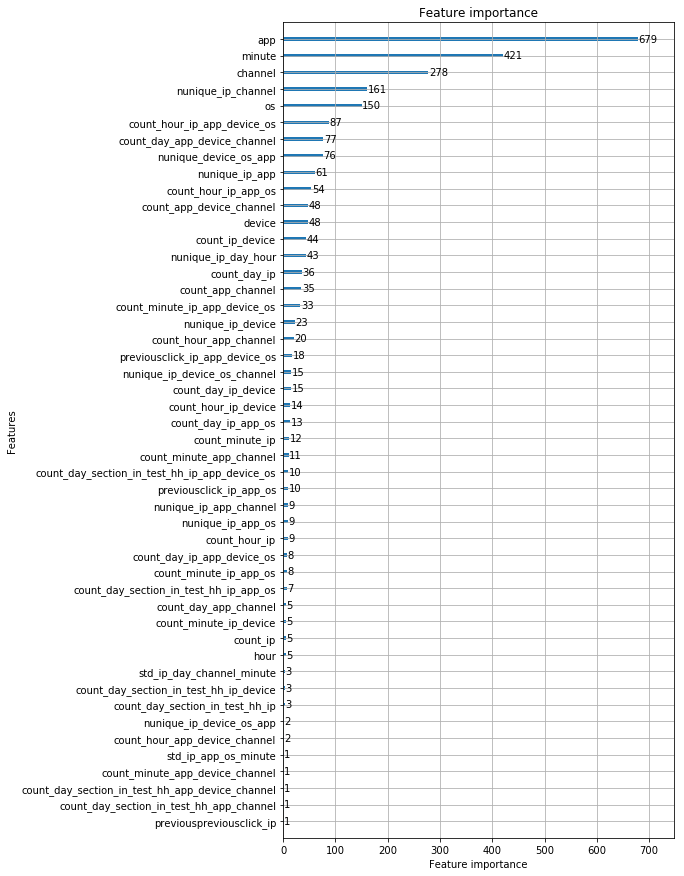

In [52]:
f, ax = plt.subplots(figsize=[7,15])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

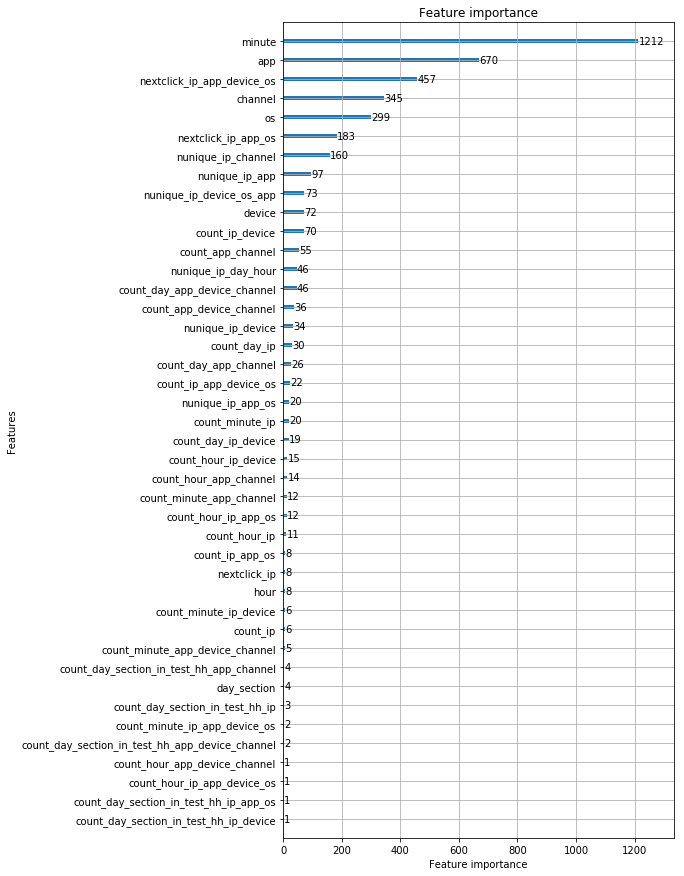

In [57]:
f, ax = plt.subplots(figsize=[7,15])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [65]:
import pickle

In [66]:
with open('../results/{}.pickle'.format(to_get), 'wb') as f:
    pickle.dump(lgb_model, f)

## Create submission

In [67]:
test = pd.read_hdf(hdf_path, key='test')

In [68]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [69]:
test_all_comb_feats =[(test, comb_feat) for comb_feat in all_comb_feats]

In [70]:
test_all_comb_feats = [comb for comb in test_all_comb_feats if 'ip' in comb[1]]

In [71]:
test = process(test, test_all_comb_feats, to_get)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting next click...
2018-04-23 15:43:53.269033


  0%|          | 0/16 [00:00<?, ?it/s]

Concat...


100%|██████████| 16/16 [00:26<00:00,  1.87s/it]


In [72]:
test.head()

,click_id,ip,app,device,os,channel,click_time,hour,minute,in_test_hh,...,nextclick_ip_app_device_os,nextnextclick_ip_app_device_os,nextclick_ip_app_device_channel,nextnextclick_ip_app_device_channel,nextclick_ip_app_os_channel,nextnextclick_ip_app_os_channel,nextclick_ip_device_os_channel,nextnextclick_ip_device_os_channel,nextclick_ip_app_device_os_channel,nextnextclick_ip_app_device_os_channel
0,0,5744,9,1,3,107,2017-11-10 04:00:00,4,240,1,...,-1,-1,1434,4560,-1,-1,-1,-1,-1,-1
1,1,119901,9,1,3,466,2017-11-10 04:00:00,4,240,1,...,399,750,359,580,18377,-1,18377,-1,18377,-1
2,2,72287,21,1,19,128,2017-11-10 04:00:00,4,240,1,...,88,215,88,215,88,215,88,215,88,215
3,3,78477,15,1,13,111,2017-11-10 04:00:00,4,240,1,...,425,488,3181,-1,3181,-1,3181,-1,3181,-1
4,4,123080,12,1,13,328,2017-11-10 04:00:00,4,240,1,...,1208,2750,1208,-1,1208,-1,1208,-1,1208,-1


In [54]:
train = pd.read_hdf(res_hdf_path, key='complete_features')
train_len = train.click_id.isnull().sum()
test_df = train.iloc[train_len:].copy()
del train
gc.collect()

224

In [61]:
pred = lgb_model.predict(test_df.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [62]:
test_df.loc[:, 'is_attributed'] = pred

In [63]:
test_df.loc[:, 'click_id'] = test_df.click_id.astype('int')

In [64]:
test_df.loc[:, ['click_id', 'is_attributed']].to_csv('../results/final4.csv', index=False, float_format='%.9f')

In [61]:
test_df.loc[:, ['click_id', 'is_attributed']].head()

,click_id,is_attributed
0,0,0.175618
1,1,0.079657
2,2,0.011602
3,3,0.038028
4,4,0.021625


# Gaussian Process
## Training

In [15]:
gc.collect()

0

In [16]:
gpc = GaussianProcessClassifier(n_restarts_optimizer=0, random_state=2, n_jobs=-1, copy_X_train=False)

In [20]:
columns = ['nextclick_ip_app_device_os']

In [21]:
len(columns)

1

In [22]:
gpc_model = gpc.fit(train_df.loc[:, columns], train_df.is_attributed.astype('int'))

MemoryError: 